<a href="https://colab.research.google.com/github/DougJ/DougJ.github.io/blob/master/My_of_B1_2_ML_Workshop_Students'_sheet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project

The goal of this project is to investigate different metrics for multiclass classifiction problem, such as accuracy, precision, specificity, recall, F1, npv, fpr. We investigate Caltech dataset, where images have 101 different labels. We consider micro-metrics, which are suitable for balanced datasets and macro-metrics, which give us more intuition about non-balanced datasets. We use support vector machine approach to investigate F1 metric on the test dataset.



In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
import random


from skimage.color import rgb2gray
from skimage.transform import resize

from sklearn.svm import SVC
from sklearn.utils import shuffle


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Image classification on Caltech 101

### 1.1) Download images
Download the Caltech 101 dataset from http://www.vision.caltech.edu/feifeili/Datasets.htm
add them to your working directory and run the code below to check the files and store the name of the classes in the list `labelNamesAll`.
Connect to your google drive, change directory name `IMDIR` if nessecary and run:

In [0]:
cd /content/drive/My Drive/'AI Inc'/data_sets/

/content/drive/My Drive/AI Inc/data_sets


In [0]:
ls

101_ObjectCategories.tar.gz


In [0]:
!tar --gunzip --extract --verbose --file=101_ObjectCategories.tar.gz

Streaming output truncated to the last 5000 lines.
101_ObjectCategories/chair/image_0006.jpg
101_ObjectCategories/chair/image_0007.jpg
101_ObjectCategories/chair/image_0008.jpg
101_ObjectCategories/chair/image_0010.jpg
101_ObjectCategories/chair/image_0011.jpg
101_ObjectCategories/chair/image_0012.jpg
101_ObjectCategories/chair/image_0013.jpg
101_ObjectCategories/chair/image_0014.jpg
101_ObjectCategories/chair/image_0016.jpg
101_ObjectCategories/chair/image_0017.jpg
101_ObjectCategories/chair/image_0018.jpg
101_ObjectCategories/chair/image_0019.jpg
101_ObjectCategories/chair/image_0020.jpg
101_ObjectCategories/chair/image_0022.jpg
101_ObjectCategories/chair/image_0023.jpg
101_ObjectCategories/chair/image_0024.jpg
101_ObjectCategories/chair/image_0025.jpg
101_ObjectCategories/chair/image_0026.jpg
101_ObjectCategories/chair/image_0028.jpg
101_ObjectCategories/chair/image_0029.jpg
101_ObjectCategories/chair/image_0030.jpg
101_ObjectCategories/chair/image_0031.jpg
101_ObjectCategories/chai

In [0]:
ls 101_ObjectCategories/accordion/

image_0001.jpg  image_0012.jpg  image_0023.jpg  image_0034.jpg  image_0045.jpg
image_0002.jpg  image_0013.jpg  image_0024.jpg  image_0035.jpg  image_0046.jpg
image_0003.jpg  image_0014.jpg  image_0025.jpg  image_0036.jpg  image_0047.jpg
image_0004.jpg  image_0015.jpg  image_0026.jpg  image_0037.jpg  image_0048.jpg
image_0005.jpg  image_0016.jpg  image_0027.jpg  image_0038.jpg  image_0049.jpg
image_0006.jpg  image_0017.jpg  image_0028.jpg  image_0039.jpg  image_0050.jpg
image_0007.jpg  image_0018.jpg  image_0029.jpg  image_0040.jpg  image_0051.jpg
image_0008.jpg  image_0019.jpg  image_0030.jpg  image_0041.jpg  image_0052.jpg
image_0009.jpg  image_0020.jpg  image_0031.jpg  image_0042.jpg  image_0053.jpg
image_0010.jpg  image_0021.jpg  image_0032.jpg  image_0043.jpg  image_0054.jpg
image_0011.jpg  image_0022.jpg  image_0033.jpg  image_0044.jpg  image_0055.jpg


In [0]:
## VERIFY LOCATION AND STORE LABEL NAMES

IMDIR = '/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategories'
labelNamesAll = []
for root, dirnames, filenames in os.walk(IMDIR):
    labelNamesAll.append(dirnames)
    #uncomment to check what is found in this folder
    #for filename in filenames:
        #f = os.path.join(root, filename)
        #if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
           # print(f)
labelNamesAll = labelNamesAll[0]
#The list of all labels/directories is
print(labelNamesAll)

['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 's

### 1.2) Build a reduced dataset to speed up the process.
To do so: 
- Consider only up to $K$ randomly drawn categories (start with a binary case)
- Read only up to $N$ images for each class
- Resize the images to $(imWidth*imHeight)$

The dataset should consist of a 
- Input matrix $\mathbf{X}$ of size $(K\cdot N)\times (imWidth\cdot imHeight)$ with one image in every row of the matrix. 
- Output vector $\mathbf{y}$ of size $(K\cdot N)\times 1$ with the label index of each input point in $\bf X$.
- the reduced list of the label names of size $K$ to map between the indices and the names.

**Note** than different classes may have different number of images so that the actual number of $\bf X$ and $\bf y$ is less than $K*N$

Run and understand the following code, add comments.

In [0]:
something = -np.ones([100*5,1])

In [0]:
something.shape

(500, 1)

In [0]:
def GenerateData(K, N):
  #build DATASET from K categories and (up to) N images from category
  imWidth = 100
  imHeight = 100

  #selection of label indices
  X = np.zeros([K*N,imHeight*imWidth]) #X is the imput matrix with K*N rows.
  Y = -np.ones([K*N,1])  #(K*N, 1)
  labelNames = []

  #random.seed(a=42)


  globalCount = 0
  for i in range(K): 
      while True:
          lab = random.randint(0,len(labelNamesAll)-1)
          if labelNamesAll[lab] not in labelNames:
              break
      #ADD_YOUR_COMMENT
      filedir = os.path.join(IMDIR,labelNamesAll[lab])
      print(filedir)

      #ADD_YOUR_COMMENT
      labelNames.append(labelNamesAll[lab])       

      classCount = 0
      for filename in os.listdir(filedir):
          f = os.path.join(filedir, filename)
          print(f)
          if classCount < N:
              image = skimage.io.imread(f, as_gray=True)
              image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')
              X[globalCount,:] = image.flatten()
              Y[globalCount,:] = i
              globalCount += 1
              classCount += 1

  #ADD_YOUR_COMMENT
  print(globalCount)
  X = X[:globalCount,:]
  Y = Y[:globalCount,:]

  #ADD_YOUR_COMMENT
  print(labelNames)
  print(X.shape)
  print(Y.T)
  return X, Y, labelNames

X, Y, labelNames = GenerateData(2,40)


/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategories/crocodile
/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategories/crocodile/image_0004.jpg
/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategories/crocodile/image_0005.jpg
/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategories/crocodile/image_0006.jpg
/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategories/crocodile/image_0007.jpg
/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategories/crocodile/image_0008.jpg
/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategories/crocodile/image_0010.jpg
/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategories/crocodile/image_0011.jpg
/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategories/crocodile/image_0012.jpg
/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategories/crocodile/image_0013.jpg
/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategories/crocodile/image_0014.jpg
/content/drive/My Drive/AI Inc/data_sets/101_ObjectCategor

### 1.3) Split data.
Split the dataset into train (80% of samples) and test (20% samples).

In [0]:
labelNames

['crocodile', 'butterfly']

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test  = train_test_split(X,Y, test_size = .2)

In [0]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(64, 10000)
(16, 10000)
(64, 1)
(16, 1)


### 1.4) Create an SVC model.
Train it on the train set, and test it on the test set. 

**Question**: SVMs are intrinsically binary classifiers, can you train the SVC for number of classes $K>2$? How is that achieved?

In [0]:
# Create, train and test an svm model     
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


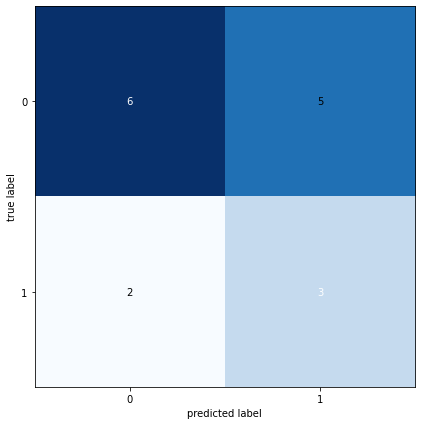

In [0]:
model = SVC()
model = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
cm_test = confusion_matrix(Y_pred, Y_test)

fig, ax = plot_confusion_matrix(conf_mat=cm_test ,  figsize=(7, 7))
plt.show()

#### check on the case with more than 2 category, for example K=3
1) accesee data,
2) split data
3) train data
4) checking performace

###1.5) Fill in the functions below.
We want to compute different evaluation measures and give a performance report**
Look at the formulas and definitions in https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)

Start by computing the confusion matrix values TP, TN, FP, FN

![Confusion Matrix](https://drive.google.com/uc?id=1KjFvShAKTXKXZXJ0ccWn6O9pMjOBVAtM)


**Question:** What are the different ways to compute and interpret the scores for multiple classes $K>2$ ? Implement them. Use https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1 for undersanding the difference between micro annd macro averaging.

**Hint** Add a numerical zero <code>eps</code> to the denominators to prevent dividing by zero

In [0]:
# Functions to compute the errors between prediction and ground truth, do one versus all predictions

def compute_measures(Y_gt,Y_pred, positiveClass=1): #Y_gt = ground truth
    measures = dict()
    Y_gt_c = np.copy(Y_gt)
    Y_pred_c = np.copy(Y_pred)
    Y_len = len(Y_gt)
    
    eps = 1e-12
    
    # one vs all
    for i in range(Y_len):
        if Y_gt[i]==positiveClass:
            Y_gt_c[i]=1
        else:
            Y_gt_c[i]=0
        if Y_pred[i]==positiveClass:
            Y_pred_c[i]=1
        else:
            Y_pred_c[i]=0
            
    #confusion matrix
    conf_mat = np.array([[0,0],[0,0]])
    for i_gt, i_pred in zip(Y_gt_c,Y_pred_c):
        conf_mat[int(i_gt), int(i_pred)]+=1
    
    # True positives TP
    TP = conf_mat[1,1] # 1 for gt and 1 for pred
        
    # True negatives TN
    TN = conf_mat[0,0]  #0 for gt and 0 for pred
    
    # False positives FP
    FP = conf_mat[0,1]  #0 for gt and 1 for pred  or 1 for gt+1 and 1 for pred
        
    # False negatives FN
    FN = conf_mat[1,0] #1 for gt and 0 for pred or 0 for gt-1 and 0 for pred

    print('TP ', TP, 'TN ', TN, 'FP', FP, 'FN', FN, 'Total', TP+TN+FP+FN)
    measures['TP'] = TP
    measures['TN'] = TN
    measures['FP'] = FP
    measures['FN'] = FN
    
    
    # Accuracy
    measures['accuracy'] = (TP+TN)/(TP+TN+FP+FN)#overall classified correctly
    
    # Precision
    measures['precision'] = TP/(FP+TP)# predicted yes, and actually yes
        
    # Specificity
    measures['specificity'] = TN/(TN+FP)#  actually no, and predict no  - Specificity
    
    # Recall
    measures['recall'] = TP/(TP+FN)
    
    # F-measure
    measures['f1'] = 2*TP/(FP+TP)*TP/(TP+FN)/((TP/(FP+TP))+ (TP/(TP+FN)))
    
    # Negative Predictive Value
    measures['npv'] = TN/(TN+FN)
    
    # False Predictive Value
    measures['fpr'] = FP+FN/(TP+TN+FP+FN)
    
    print('Accuracy ', measures['accuracy'], '\n',
          'Precision', measures['precision'], '\n',
          'Recall', measures['recall'], '\n',
          'Specificity ', measures['specificity'], '\n',
          'F-measure', measures['f1'], '\n',
          'NPV', measures['npv'],'\n',
          'FPV', measures['fpr'],'\n')


    
    return measures

mes=compute_measures(Y_test,Y_pred)
print([mes, mes])
print(np.sum(np.array([meas['TP'] for meas in [mes,mes]])))

def micro_average(measuresList):
    microAverage = dict()
    eps = 1e-12
    
    #we can divide by n=len(measuresList) but it's not necessary for the data we want to compute here. 
    sumTP = np.sum(np.array([meas['TP'] for meas in measuresList]))
    sumTN = np.sum(np.array([meas['TN'] for meas in measuresList]))
    sumFP = np.sum(np.array([meas['FP'] for meas in measuresList]))
    sumFN = np.sum(np.array([meas['FN'] for meas in measuresList]))
    
    # Accuracy
    microAverage['accuracy'] = (sumTP+sumTN)/(sumTP+sumTN+sumFP+sumFN+eps)
    
    # Precision
    microAverage['precision'] = sumTP/(sumTP+sumFP+eps)
        
    # Specificity
    microAverage['specificity'] = sumTN/(sumTN+sumFP+eps)
    
    # Recall
    microAverage['recall'] = sumTP/(sumTP+sumFN+eps)
    
    # F-measure
    microAverage['f1'] = 2*sumTP/(2*sumTP+sumFP+sumFN+eps)
    
    # Negative Predictive Value
    microAverage['npv'] = sumTN/(sumTN+sumFN+eps)
    
    # False Predictive Value
    microAverage['fpr'] = sumFP/(sumFP+sumTN+eps)
    
        
    print('Accuracy ', microAverage['accuracy'], '\n',
          'Precision', microAverage['precision'], '\n',
          'Recall', microAverage['recall'], '\n',
          'Specificity ', microAverage['specificity'], '\n',
          'F-measure', microAverage['f1'], '\n',
          'NPV', microAverage['npv'],'\n',
          'FPV', microAverage['fpr'],'\n')
    
    return microAverage

def macro_average(measuresList):
    macroAverage = dict()
    

    # Accuracy
    macroAverage['accuracy'] = np.mean(np.array([meas['accuracy'] for meas in measuresList]))
    
    # Precision
    macroAverage['precision'] = np.mean(np.array([meas['precision'] for meas in measuresList]))
        
    # Specificity
    macroAverage['specificity']= np.mean(np.array([meas['specificity'] for meas in measuresList]))
    
    # Recall
    macroAverage['recall'] = np.mean(np.array([meas['recall'] for meas in measuresList]))
    
    # F-measure
    macroAverage['f1'] = np.mean(np.array([meas['f1'] for meas in measuresList]))
    
    # Negative Predictive Value
    macroAverage['npv'] = np.mean(np.array([meas['npv'] for meas in measuresList]))
    
    # False Predictive Value
    macroAverage['fpr'] = np.mean(np.array([meas['fpr'] for meas in measuresList]))
    
    print('Accuracy ', macroAverage['accuracy'], '\n',
          'Precision', macroAverage['precision'], '\n',
          'Recall', macroAverage['recall'], '\n',
          'Specificity ', macroAverage['specificity'], '\n',
          'F-measure', macroAverage['f1'], '\n',
          'NPV', macroAverage['npv'],'\n',
          'FPV', macroAverage['fpr'],'\n')
    
    return macroAverage

print(micro_average([mes]))


TP  3 TN  6 FP 2 FN 5 Total 16
Accuracy  0.5625 
 Precision 0.6 
 Recall 0.375 
 Specificity  0.75 
 F-measure 0.4615384615384615 
 NPV 0.5454545454545454 
 FPV 2.3125 

[{'TP': 3, 'TN': 6, 'FP': 2, 'FN': 5, 'accuracy': 0.5625, 'precision': 0.6, 'specificity': 0.75, 'recall': 0.375, 'f1': 0.4615384615384615, 'npv': 0.5454545454545454, 'fpr': 2.3125}, {'TP': 3, 'TN': 6, 'FP': 2, 'FN': 5, 'accuracy': 0.5625, 'precision': 0.6, 'specificity': 0.75, 'recall': 0.375, 'f1': 0.4615384615384615, 'npv': 0.5454545454545454, 'fpr': 2.3125}]
6
Accuracy  0.5624999999999649 
 Precision 0.59999999999988 
 Recall 0.37499999999995315 
 Specificity  0.7499999999999063 
 F-measure 0.46153846153842604 
 NPV 0.5454545454544959 
 FPV 0.24999999999996875 

{'accuracy': 0.5624999999999649, 'precision': 0.59999999999988, 'specificity': 0.7499999999999063, 'recall': 0.37499999999995315, 'f1': 0.46153846153842604, 'npv': 0.5454545454544959, 'fpr': 0.24999999999996875}


###1.6) Measure the performance of the SVC model for multiple classes $K>2$ witht the preformace function, macro_average, micro_average, defined above, in the case K=3 or other number K>2 you have tested. Check the result with the output of Sklearn classification report, why they are a bit different? 

In [0]:
#Fill in a list of measure dictionaries taking as input a different positive class

multiclass = []
K=
for k in range(K):
    print('For class',labelNames[k])
    multiclass.append(compute_measures())

print('Macro-average')

    
print('Micro-average')


from sklearn.metrics import classification_report #confusion_matrix, accuracy_score, precision_score, recall_score, f1_micro, f1_macro
print(classification_report())

### 1.7) Visualization:
Show the test images as well as the predictions `Y_pred` vs the ground truth `Y_gt` labels for the best model. Investigate and run the following function:


In [0]:
# Show some results

def ShowImages(X_test,Y_test,Y_pred,labelNames):
  width=20
  height=15
  plt.rcParams['figure.figsize'] = [width, height]
  fig=plt.figure()
  imCounter = 1
  imHeight=100
  imWidth=100
  for i in range(len(Y_test)):
      image=np.reshape(X_test[i,:], (imHeight,imWidth))
      plt.subplot(5,7,imCounter)
      plt.imshow(image,cmap='gray')
      plt.axis('off')
      gtLabel = labelNames[Y_test.ravel()[i].astype(int)]
      predLabel = labelNames[Y_pred.ravel()[i].astype(int)]
      plt.title('GT: {}. \n Pred: {}'.format(gtLabel, predLabel))
      imCounter += 1
  plt.show()
ShowImages(X_test,Y_test,Y_pred, lableName)


### 1.8) Make predictions.
Change the hyperparameters of your SVC trying to optimize the F1 measure for different cases. Describe in your report the different variants of the model you tried. Present and discuss your results for different hyperparameters, number of classes and numbers of images. 

You can also use gridesearch to test it

**This is the most important part: to see how good you algorighm can generalize.**

##1.9) Optional
Pick a model of your choice (you can find one at https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) and try it on this problem. Once you are confident with this first one, try several other models and compare their performances.